This notebook is about clustering tcr. In this part, we will use guassian mixture to do clustering.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from sklearn.manifold import MDS
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from tcrdist.repertoire import TCRrep

In [71]:
# load data
data = pd.read_csv('vdjdb.txt', sep = '\t')
score = data[data['vdjdb.score'].isin([1, 2, 3])]
data = data.drop(['web.method', 'web.method.seq', 'web.cdr3fix.nc','web.cdr3fix.unmp','reference.id', 'method', 'meta', 'cdr3fix'], axis=1)
data = data.dropna()

# alpha human
data_alpha_human_sampled = score[(score['gene'] == 'TRA') & (score['species'] == 'HomoSapiens')]
data_alpha_human_sampled = data_alpha_human_sampled.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})
# alpha mouse
data_alpha = data[(data['gene'] == 'TRA')]
data_alpha_mouse = data_alpha[(data_alpha['species'] == 'MusMusculus')]
data_alpha_mouse = data_alpha_mouse.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})
# beta human
data_beta_human_sampled = score[(score['gene'] == 'TRB') & (score['species'] == 'HomoSapiens')& (score['complex.id'] == 0)]
data_beta_human_sampled = data_beta_human_sampled.rename(columns = {'gene':'gene_b',
                                           'cdr3':'cdr3_b_aa',
                                           'v.segm':'v_b_gene',
                                           'j.segm':'j_b_gene'})
# beta mouse
data_beta = data[(data['gene'] == 'TRB')]
data_beta_mouse = data_beta[(data_beta['species'] == 'MusMusculus')]
data_beta_mouse = data_beta_mouse.rename(columns = {'gene':'gene_b',
                                           'cdr3':'cdr3_b_aa',
                                           'v.segm':'v_b_gene',
                                           'j.segm':'j_b_gene'})

Compute distance

In [72]:
# alpha human
tr_human_alpha = TCRrep(cell_df = data_alpha_human_sampled, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')
alpha_human_distance = tr_human_alpha.pw_alpha
alpha_human_clone_df = tr_human_alpha.clone_df

# beta human
tr_human_beta = TCRrep(cell_df = data_beta_human_sampled, 
            organism = 'human', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')
beta_human_distance = tr_human_beta.pw_beta
beta_human_clone_df = tr_human_beta.clone_df

# alpha mouse
tr_alpha = TCRrep(cell_df = data_alpha_mouse, 
            organism = 'mouse', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')
mouse_alpha_distance = tr_alpha.pw_alpha
mouse_alpha_clone_df = tr_alpha.clone_df

# beta mouse
tr_beta = TCRrep(cell_df = data_beta_mouse, 
            organism = 'mouse', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')
mouse_beta_distance = tr_beta.pw_beta
mouse_beta_clone_df = tr_beta.clone_df

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x00000170A2022AC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.182 of 2911 were not 

# alpha human

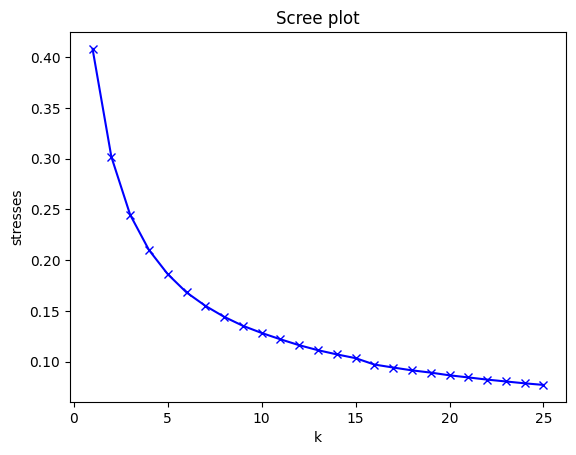

In [14]:
# decide the value of n_component of mds
stresses_alpha_human = []
K = 25
for k in range(1, K+1):
    mds = MDS(n_components=k, dissimilarity="precomputed", metric=False, normalized_stress=True, random_state=42)
    mds.fit(alpha_human_distance)
    stresses_alpha_human.append(mds.stress_)

plt.figure()
plt.plot(range(1, K+1), stresses_alpha_human, 'bx-')
plt.xlabel('k')
plt.ylabel('stresses')
plt.title('Scree plot')
plt.savefig('alpha_human_scree.png')
plt.show()

In [73]:
mds = MDS(n_components=8, dissimilarity="precomputed", metric=True, random_state=42)
cluster_positions_alpha_human = mds.fit_transform(alpha_human_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


Gaussian mixture

In [74]:
alpha_human_clone_df_features = alpha_human_clone_df[['antigen.species']]
dis_alpha_human = pd.DataFrame(cluster_positions_alpha_human)
con_alpha_human = pd.concat([alpha_human_clone_df_features, dis_alpha_human], axis=1)
con_alpha_human = con_alpha_human[con_alpha_human['antigen.species'].isin(['CMV', 'EBV', 'HCV', 'HIV-1', 'HomoSapiens', 'InfluenzaA', 'SARS-CoV-2', 'YFV'])]

In [75]:
gaussian_init_alpha_human = con_alpha_human.groupby('antigen.species').mean()

gmm = GaussianMixture(n_components=8, max_iter=300, means_init=gaussian_init_alpha_human, random_state=42)

gmm.fit(cluster_positions_alpha_human)

alpha_human_labels = gmm.predict(cluster_positions_alpha_human)
alpha_human_clone_df['label'] = alpha_human_labels
alpha_human_cluster_results = np.column_stack((cluster_positions_alpha_human, alpha_human_labels))

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


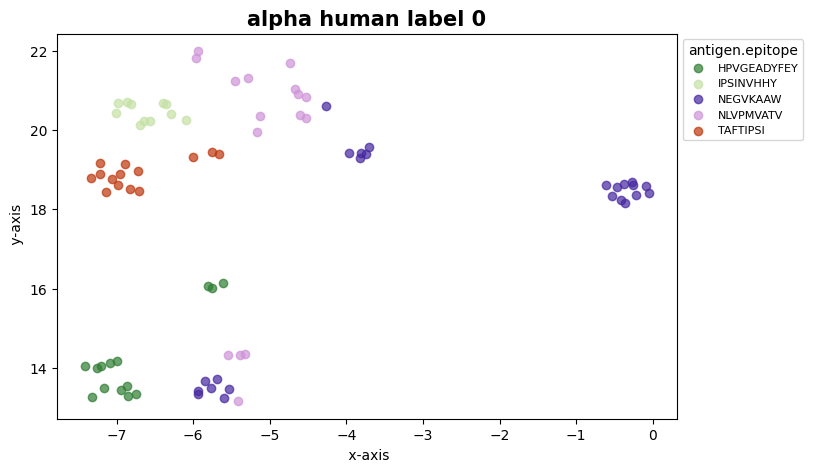

In [76]:
label = 0
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_0_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_0 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=40, min_dist=0.2, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_0_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_0['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_0['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_0 = clone_df_0[mask]
filtered_embedding0 = embedding0[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_0['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_0['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding0[true_indices, 0], filtered_embedding0[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 0', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_0')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


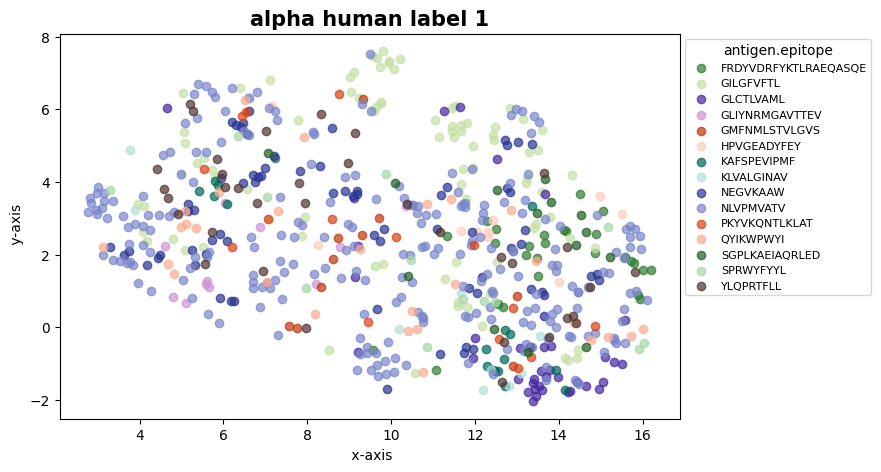

In [77]:
label = 1
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_1_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_1 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=140, min_dist=0.9, random_state=42)
embedding1 = reducer_umap.fit_transform(cluster_1_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_1['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_1['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_1 = clone_df_1[mask]
filtered_embedding1 = embedding1[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_1['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_1['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding1[true_indices, 0], filtered_embedding1[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 1', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_1')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


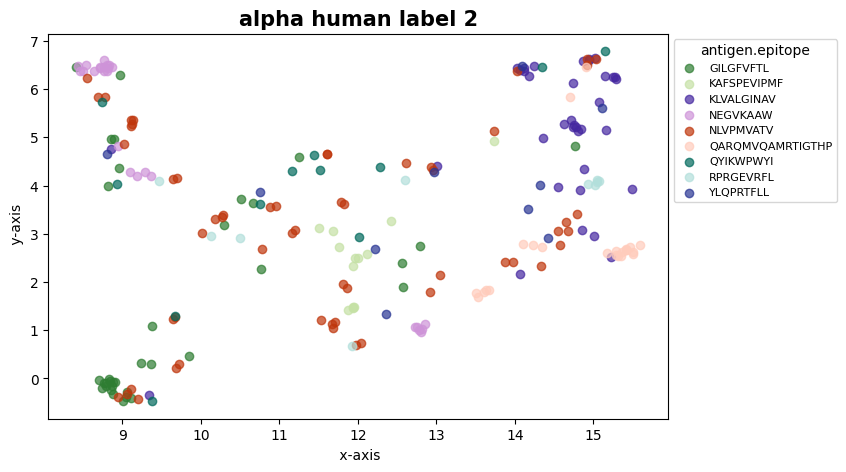

In [78]:
label = 2
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_2_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_2 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=50, min_dist=0.1, random_state=42)
embedding2 = reducer_umap.fit_transform(cluster_2_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_2['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_2['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_2 = clone_df_2[mask]
filtered_embedding2 = embedding2[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_2['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_2['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding2[true_indices, 0], filtered_embedding2[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 2', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_2')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.


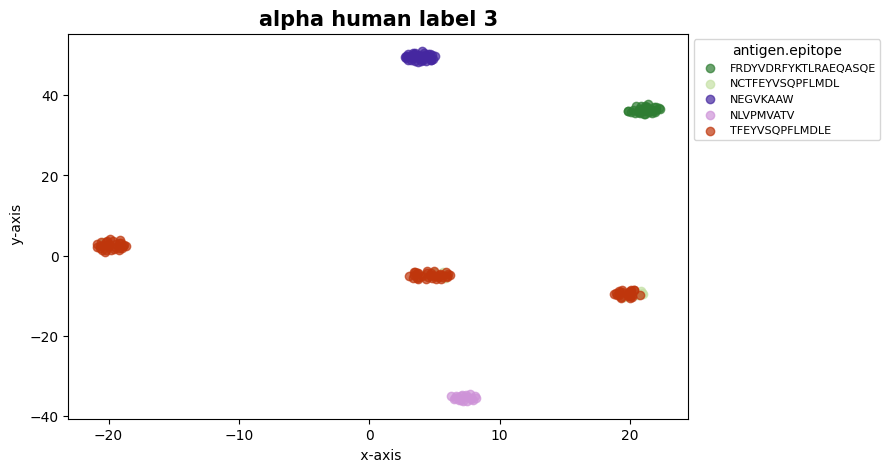

In [79]:
label = 3
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_3_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_3 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=100, min_dist=0.9, random_state=42)
embedding3 = reducer_umap.fit_transform(cluster_3_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_3['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_3['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_3 = clone_df_3[mask]
filtered_embedding3 = embedding3[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_3['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_3['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding3[true_indices, 0], filtered_embedding3[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 3', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_3')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


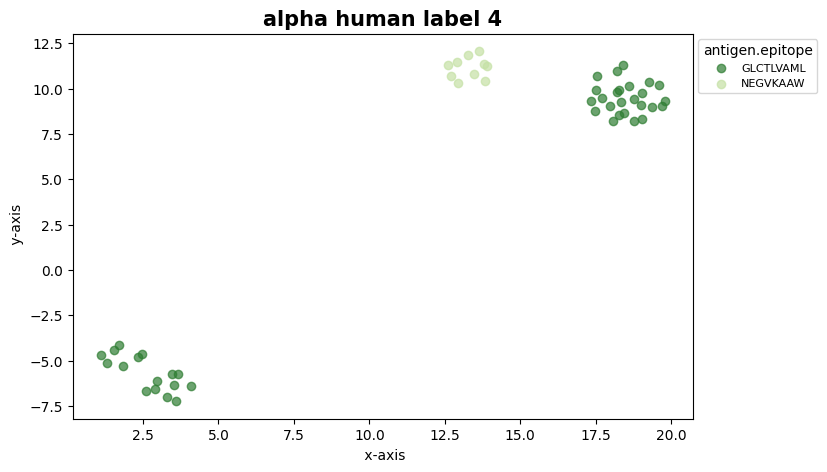

In [80]:
label = 4
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_4_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_4 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=140, min_dist=0.9, random_state=42)
embedding4 = reducer_umap.fit_transform(cluster_4_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_4['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_4['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_4 = clone_df_4[mask]
filtered_embedding4 = embedding4[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_4['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_4['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding4[true_indices, 0], filtered_embedding4[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 4', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_4')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


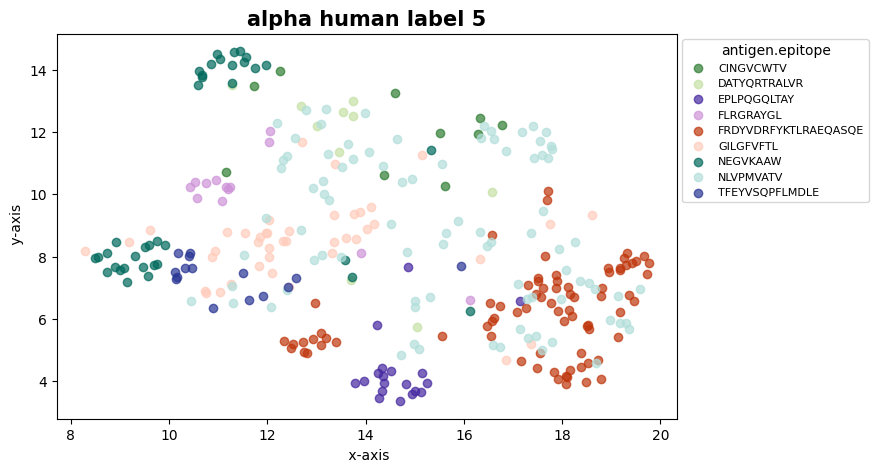

In [81]:
label = 5
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_5_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_5 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=140, min_dist=0.9, random_state=42)
embedding5 = reducer_umap.fit_transform(cluster_5_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_5['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_5['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_5 = clone_df_5[mask]
filtered_embedding5 = embedding5[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_5['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_5['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding5[true_indices, 0], filtered_embedding5[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 5', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_5')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


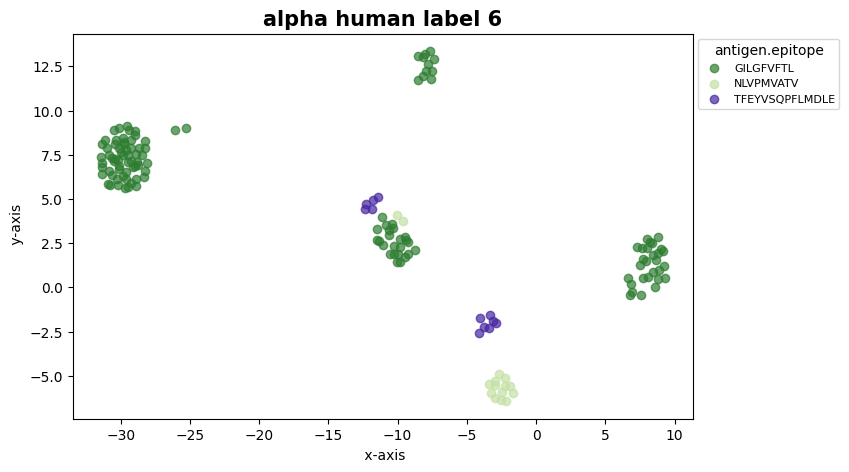

In [82]:
label = 6
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_6_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_6 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=140, min_dist=0.9, random_state=42)
embedding6 = reducer_umap.fit_transform(cluster_6_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_6['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_6['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_6 = clone_df_6[mask]
filtered_embedding6 = embedding6[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_6['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_6['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding6[true_indices, 0], filtered_embedding6[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 6', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_6')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


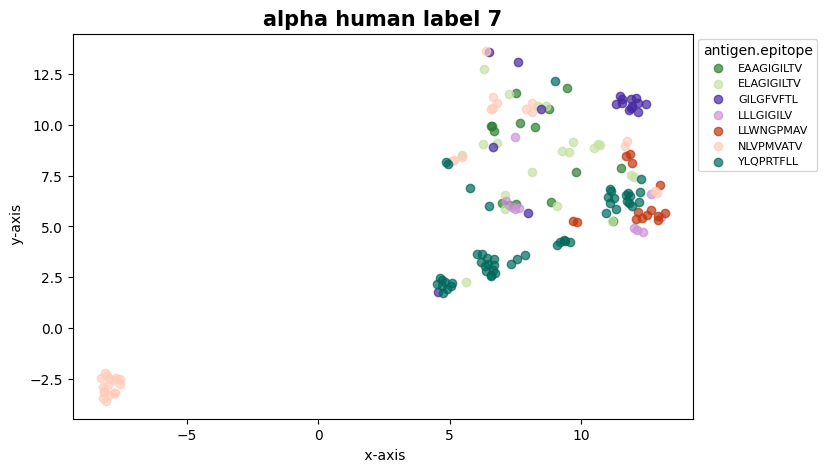

In [83]:
label = 7
bool = np.isin(alpha_human_cluster_results[:, -1], label)
cluster_7_coordinate = alpha_human_cluster_results[bool][:, 0:-1]
clone_df_7 = alpha_human_clone_df[alpha_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=20, min_dist=0.5, random_state=42)
embedding7 = reducer_umap.fit_transform(cluster_7_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_7['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_7['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_7 = clone_df_7[mask]
filtered_embedding7 = embedding7[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_7['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_7['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding7[true_indices, 0], filtered_embedding7[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha human label 7', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_7')
plt.show()

# beta human

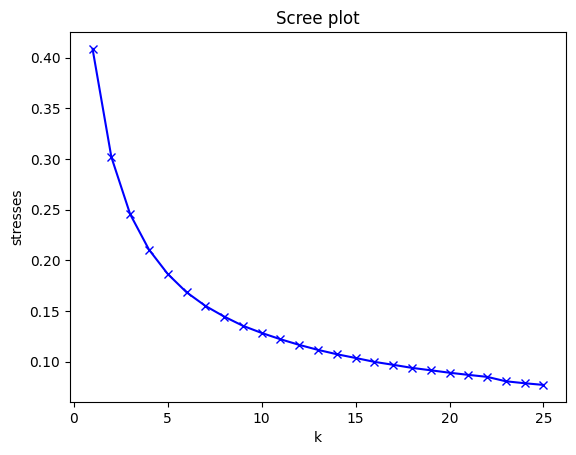

In [27]:
# decide the value of n_component of mds
stresses_beta_human = []
K = 25
for k in range(1, K+1):
    mds = MDS(n_components=k, dissimilarity="precomputed", metric=False, normalized_stress=True, random_state=42)
    mds.fit(beta_human_distance)
    stresses_beta_human.append(mds.stress_)

plt.figure()
plt.plot(range(1, K+1), stresses_beta_human, 'bx-')
plt.xlabel('k')
plt.ylabel('stresses')
plt.title('Scree plot')
plt.savefig('beta_human_scree.png')
plt.show()

In [84]:
mds = MDS(n_components=8, dissimilarity="precomputed", metric=True, random_state=42)
cluster_positions_beta_human = mds.fit_transform(beta_human_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


In [85]:
beta_human_clone_df_features = beta_human_clone_df[['antigen.species']]
dis_beta_human = pd.DataFrame(cluster_positions_beta_human)
con_beta_human = pd.concat([beta_human_clone_df_features, dis_beta_human], axis=1)
con_beta_human = con_beta_human[con_beta_human['antigen.species'].isin(['CMV', 'EBV', 'HCV', 'HIV-1', 'HomoSapiens', 'InfluenzaA', 'SARS-CoV-2', 'Wheat'])]

In [86]:
gaussian_init_beta_human = con_beta_human.groupby('antigen.species').mean()

gmm = GaussianMixture(n_components=8, max_iter=300, means_init=gaussian_init_beta_human, random_state=42)

gmm.fit(cluster_positions_beta_human)

labels_beta_human = gmm.predict(cluster_positions_beta_human)
beta_human_clone_df['label'] = labels_beta_human
beta_human_cluster_results = np.column_stack((cluster_positions_beta_human, labels_beta_human))

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


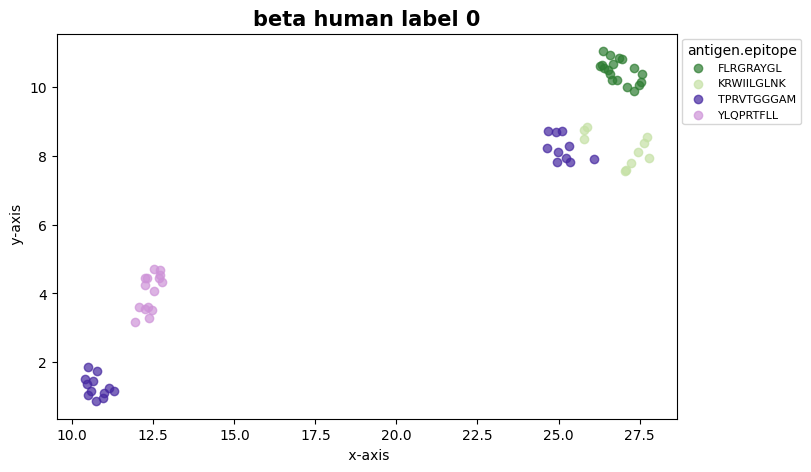

In [87]:
label = 0
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_0_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_0 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=60, min_dist=0.25, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_0_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_0['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_0['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_0 = clone_df_0[mask]
filtered_embedding0 = embedding0[mask]


color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_0['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_0['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding0[true_indices, 0], filtered_embedding0[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 0', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_0')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


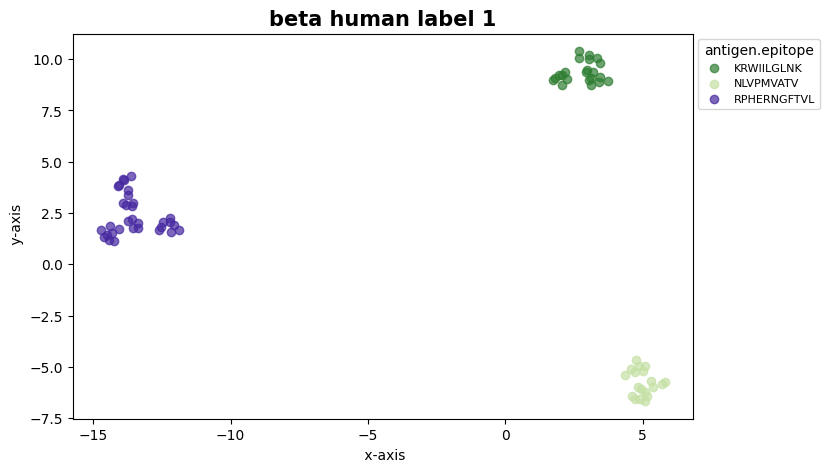

In [88]:
label = 1
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_1_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_1 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=50, min_dist=0.25, random_state=42)
embedding1 = reducer_umap.fit_transform(cluster_1_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_1['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_1['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_1 = clone_df_1[mask]
filtered_embedding1 = embedding1[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_1['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_1['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding1[true_indices, 0], filtered_embedding1[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 1', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_1')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


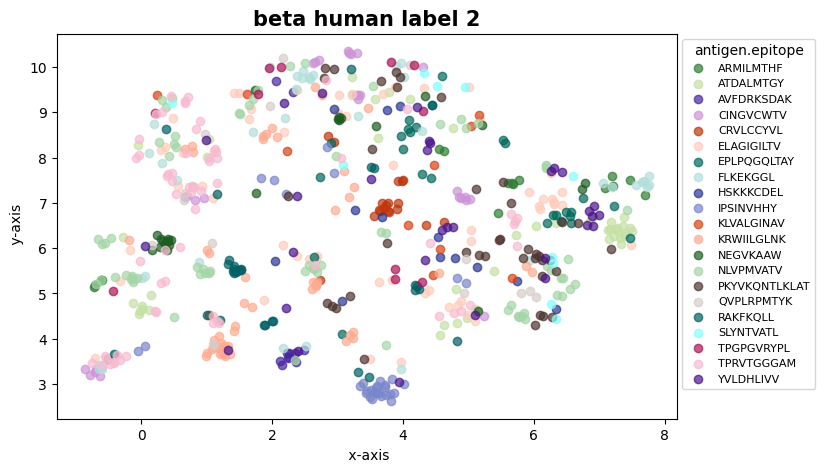

In [89]:
label = 2
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_2_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_2 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=150, min_dist=0.3, random_state=42)
embedding2 = reducer_umap.fit_transform(cluster_2_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_2['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_2['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_2 = clone_df_2[mask]
filtered_embedding2 = embedding2[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_2['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_2['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding2[true_indices, 0], filtered_embedding2[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 2'.format('beta'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_2')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


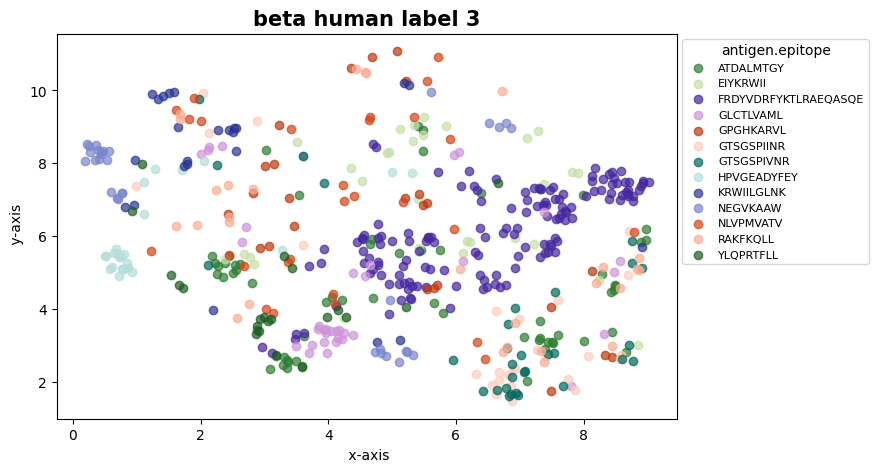

In [90]:
label = 3
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_3_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_3 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=200, min_dist=0.5, random_state=42)
embedding3 = reducer_umap.fit_transform(cluster_3_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_3['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 20].index

# Search those specificities
mask = clone_df_3['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_3 = clone_df_3[mask]
filtered_embedding3 = embedding3[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_3['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_3['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding3[true_indices, 0], filtered_embedding3[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 3', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_3')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


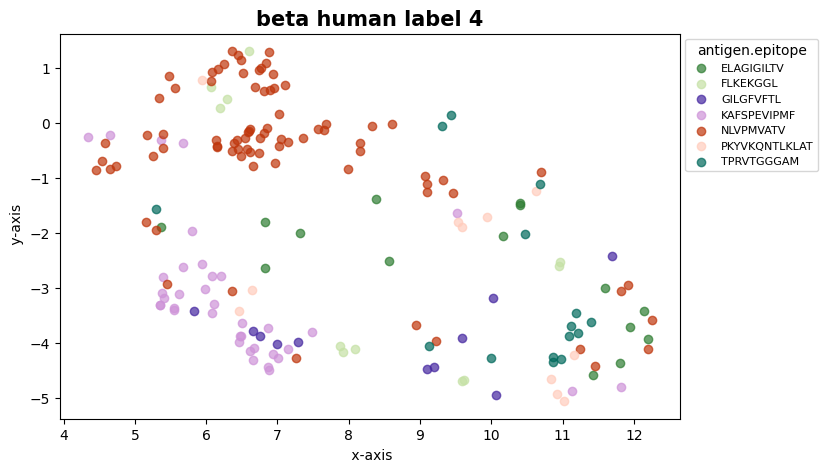

In [91]:
label = 4
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_4_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_4 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=100, min_dist=0.3, random_state=42)
embedding4 = reducer_umap.fit_transform(cluster_4_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_4['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_4['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_4 = clone_df_4[mask]
filtered_embedding4 = embedding4[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_4['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_4['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding4[true_indices, 0], filtered_embedding4[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 4', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_4')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


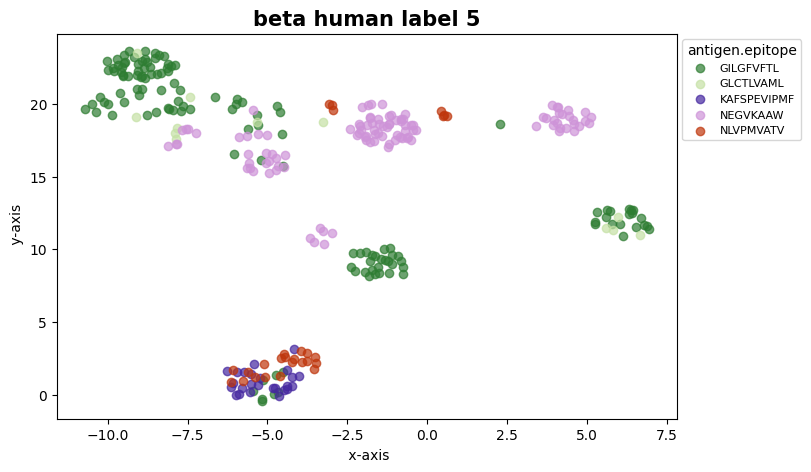

In [92]:
label = 5
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_5_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_5 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=500, min_dist=0.9, random_state=42)
embedding5 = reducer_umap.fit_transform(cluster_5_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_5['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_5['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_5 = clone_df_5[mask]
filtered_embedding5 = embedding5[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_5['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_5['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding5[true_indices, 0], filtered_embedding5[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 5', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_5')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


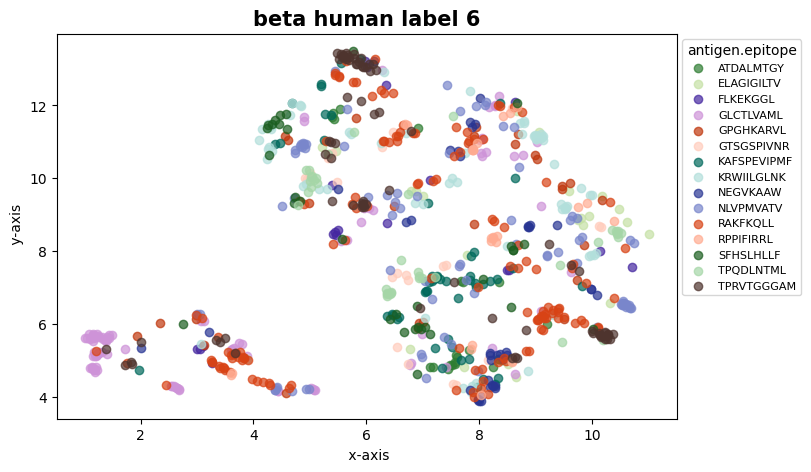

In [93]:
label = 6
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_6_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_6 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=100, min_dist=0.2, random_state=42)
embedding6 = reducer_umap.fit_transform(cluster_6_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_6['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 20].index

# Search those specificities
mask = clone_df_6['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_6 = clone_df_6[mask]
filtered_embedding6 = embedding6[mask]


color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_6['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_6['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding6[true_indices, 0], filtered_embedding6[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 6', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_6')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


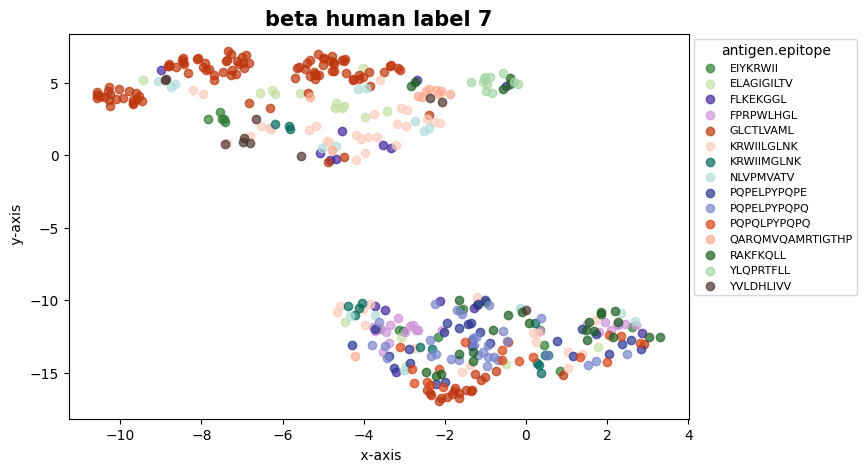

In [94]:
label = 7
bool = np.isin(beta_human_cluster_results[:, -1], label)
cluster_7_coordinate = beta_human_cluster_results[bool][:, 0:-1]
clone_df_7 = beta_human_clone_df[beta_human_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=140, min_dist=0.9, random_state=42)
embedding7 = reducer_umap.fit_transform(cluster_7_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_7['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_7['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_7 = clone_df_7[mask]
filtered_embedding7 = embedding7[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_7['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_7['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding7[true_indices, 0], filtered_embedding7[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta human label 7', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('beta_7')
plt.show()

# alpha mouse

In [40]:
alpha_mouse = TCRrep(cell_df = data_alpha_mouse, 
            organism = 'mouse', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

mouse_alpha_distance = alpha_mouse.pw_alpha
mouse_alpha_clone_df = alpha_mouse.clone_df

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x00000170A2022AC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


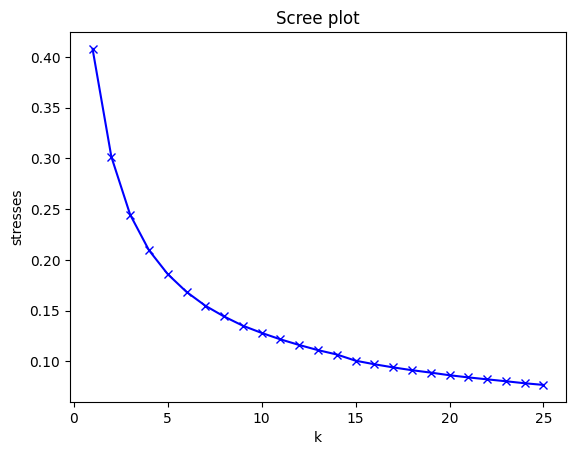

In [41]:
stresses_mouse_alpha = []
K = 25
for k in range(1, K+1):
    mds = MDS(n_components=k, dissimilarity="precomputed", metric=False, normalized_stress=True, random_state=42)
    mds.fit(mouse_alpha_distance)
    stresses_mouse_alpha.append(mds.stress_)

plt.figure()
plt.plot(range(1, K+1), stresses_mouse_alpha, 'bx-')
plt.xlabel('k')
plt.ylabel('stresses')
plt.title('Scree plot')
plt.savefig('mouse_alpha_scree.png')
plt.show()

In [42]:
mds = MDS(n_components=8, dissimilarity="precomputed", metric=True, random_state=42)
cluster_positions_alpha = mds.fit_transform(mouse_alpha_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


In [43]:
clone_df_features = mouse_alpha_clone_df[['antigen.species']]
dis = pd.DataFrame(cluster_positions_alpha)
con = pd.concat([clone_df_features, dis], axis=1)
con = con[con['antigen.species'].isin(['InfluenzaA', 'MCMV', 'LCMV', 'PlasmodiumBerghei', 'MusMusculus'])]

In [44]:
gaussian_init = con.groupby('antigen.species').mean()

gmm = GaussianMixture(n_components=5, max_iter=300, means_init=gaussian_init, random_state=42)

gmm.fit(cluster_positions_alpha)

labels = gmm.predict(cluster_positions_alpha)
mouse_alpha_clone_df['label'] = labels
cluster_results = np.column_stack((cluster_positions_alpha, labels))

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


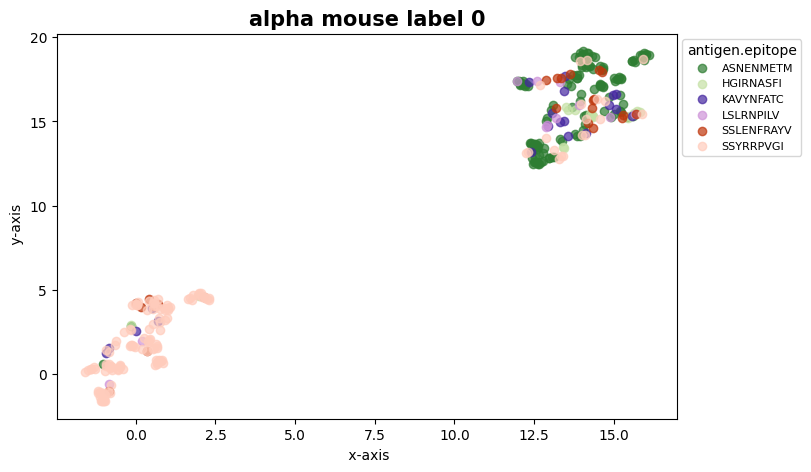

In [45]:
label = 0
bool = np.isin(cluster_results[:, -1], label)
cluster_0_coordinate = cluster_results[bool][:, 0:-1]
clone_df_0 = mouse_alpha_clone_df[mouse_alpha_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=60, min_dist=0.2, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_0_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_0['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_0['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_0 = clone_df_0[mask]
filtered_embedding0 = embedding0[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_0['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_0['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding0[true_indices, 0], filtered_embedding0[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha mouse label 0', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_alpha_0.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


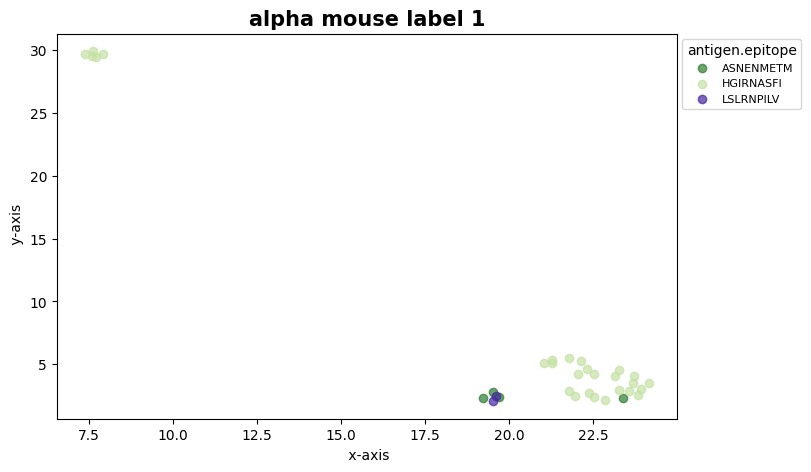

In [46]:
label = 1
bool = np.isin(cluster_results[:, -1], label)
cluster_1_coordinate = cluster_results[bool][:, 0:-1]
clone_df_1 = mouse_alpha_clone_df[mouse_alpha_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
embedding1 = reducer_umap.fit_transform(cluster_1_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_1['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 0].index

# Search those specificities
mask = clone_df_1['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_1 = clone_df_1[mask]
filtered_embedding1 = embedding1[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_1['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_1['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding1[true_indices, 0], filtered_embedding1[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha mouse label 1', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_alpha_1.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


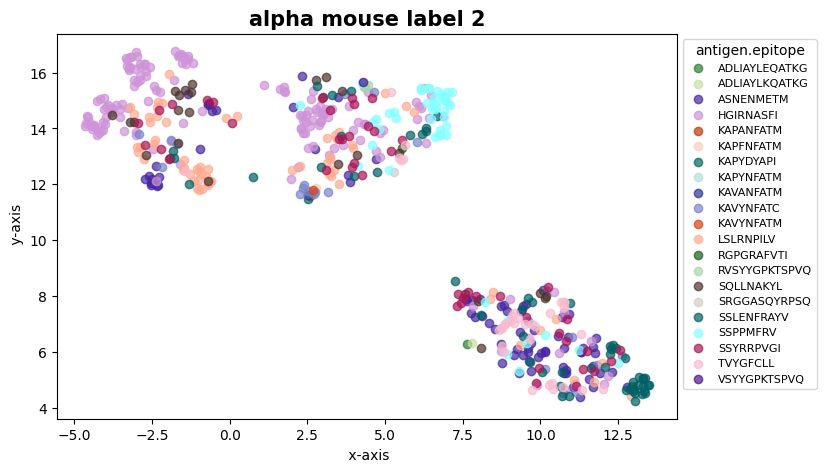

In [47]:
label = 2
bool = np.isin(cluster_results[:, -1], label)
cluster_2_coordinate = cluster_results[bool][:, 0:-1]
clone_df_2 = mouse_alpha_clone_df[mouse_alpha_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=90, min_dist=0.5, random_state=42)
embedding2 = reducer_umap.fit_transform(cluster_2_coordinate)

# count the appearance times of each specificity
specificity_counts = clone_df_2['antigen.epitope'].value_counts()

# find out the specificities' number larger 0
valid_specificity = specificity_counts[specificity_counts >= 0].index

# Search those specificities
mask = clone_df_2['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_2 = clone_df_2[mask]
filtered_embedding2 = embedding2[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_2['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_2['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding2[true_indices, 0], filtered_embedding2[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha mouse label 2', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_alpha_2.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


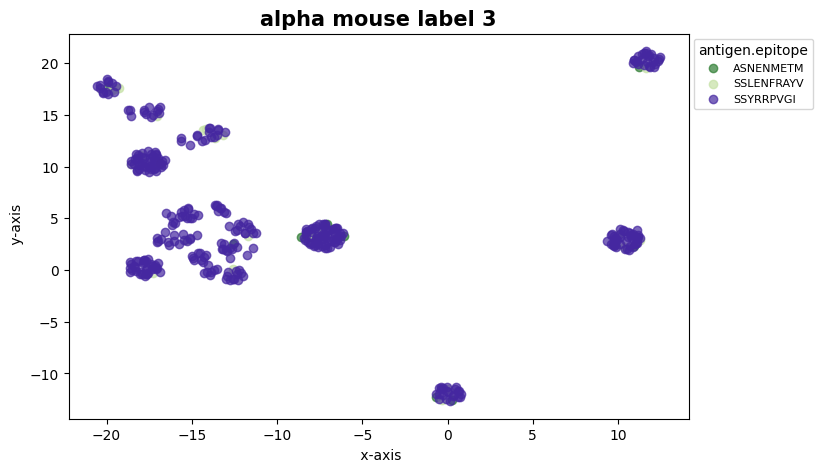

In [48]:
label = 3
bool = np.isin(cluster_results[:, -1], label)
cluster_3_coordinate = cluster_results[bool][:, 0:-1]
clone_df_3 = mouse_alpha_clone_df[mouse_alpha_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=200, min_dist=0.9, random_state=42)
embedding3 = reducer_umap.fit_transform(cluster_3_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_3['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_3['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_3 = clone_df_3[mask]
filtered_embedding3 = embedding3[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_3['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_3['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding3[true_indices, 0], filtered_embedding3[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha mouse label 3', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_alpha_3.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


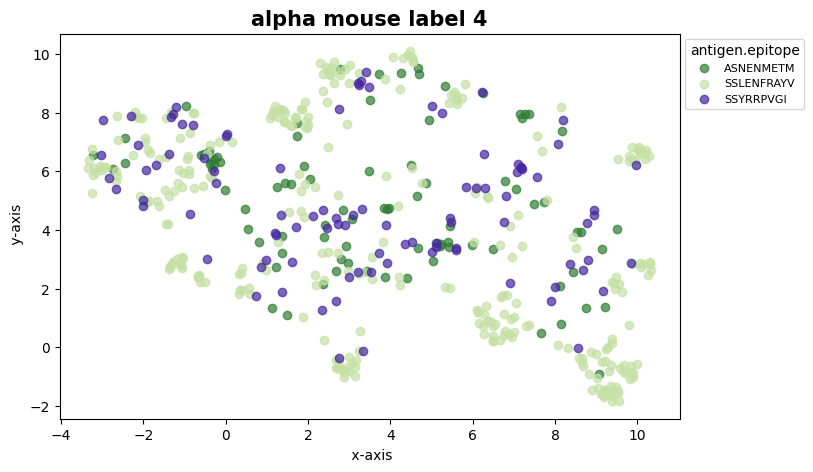

In [49]:
label = 4
bool = np.isin(cluster_results[:, -1], label)
cluster_4_coordinate = cluster_results[bool][:, 0:-1]
clone_df_4 = mouse_alpha_clone_df[mouse_alpha_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=30, min_dist=0.5, random_state=42)
embedding4 = reducer_umap.fit_transform(cluster_4_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_4['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_4['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_4 = clone_df_4[mask]
filtered_embedding4 = embedding4[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_3['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_4['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding4[true_indices, 0], filtered_embedding4[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('alpha mouse label 4', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_alpha_4.png')
plt.show()

# beta mouse

In [50]:
beta_mouse = TCRrep(cell_df = data_beta_mouse, 
            organism = 'mouse', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')
mouse_beta_distance = beta_mouse.pw_beta
mouse_beta_clone_df = beta_mouse.clone_df

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x00000170A2022AC0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


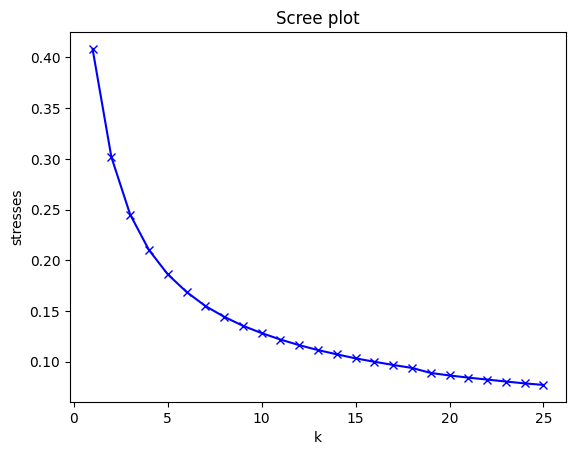

In [52]:
stresses_mouse_beta = []
K = 25
for k in range(1, K+1):
    mds = MDS(n_components=k, dissimilarity="precomputed", metric=False, normalized_stress=True, random_state=42)
    mds.fit(mouse_beta_distance)
    stresses_mouse_beta.append(mds.stress_)

plt.figure()
plt.plot(range(1, K+1), stresses_mouse_beta, 'bx-')
plt.xlabel('k')
plt.ylabel('stresses')
plt.title('Scree plot')
plt.savefig('mouse_beta_scree.png')
plt.show()

In [53]:
mds = MDS(n_components=8, dissimilarity="precomputed", metric=True, random_state=42)
cluster_positions_beta = mds.fit_transform(mouse_beta_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


In [54]:
clone_df_features = mouse_beta_clone_df[['antigen.species']]
dis = pd.DataFrame(cluster_positions_beta)
con = pd.concat([clone_df_features, dis], axis=1)
con = con[con['antigen.species'].isin(['InfluenzaA', 'MCMV', 'LCMV', 'PlasmodiumBerghei', 'MusMusculus'])]

In [55]:
gaussian_init = con.groupby('antigen.species').mean()

gmm = GaussianMixture(n_components=5, max_iter=300, means_init=gaussian_init, random_state=42)

gmm.fit(cluster_positions_beta)

labels = gmm.predict(cluster_positions_beta)
mouse_beta_clone_df['label'] = labels
cluster_results = np.column_stack((cluster_positions_beta, labels))

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


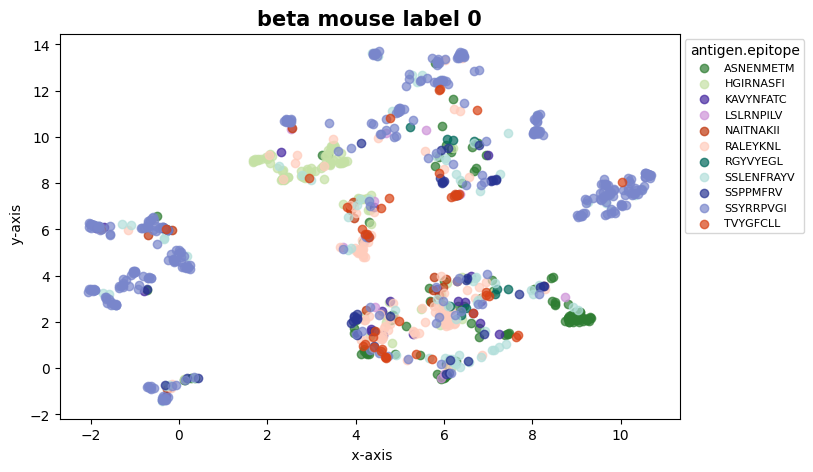

In [56]:
label = 0
bool = np.isin(cluster_results[:, -1], label)
cluster_0_coordinate = cluster_results[bool][:, 0:-1]
clone_df_0 = mouse_beta_clone_df[mouse_beta_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=40, min_dist=0.2, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_0_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_0['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_0['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_0 = clone_df_0[mask]
filtered_embedding0 = embedding0[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_0['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_0['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding0[true_indices, 0], filtered_embedding0[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta mouse label 0', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_beta_0.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


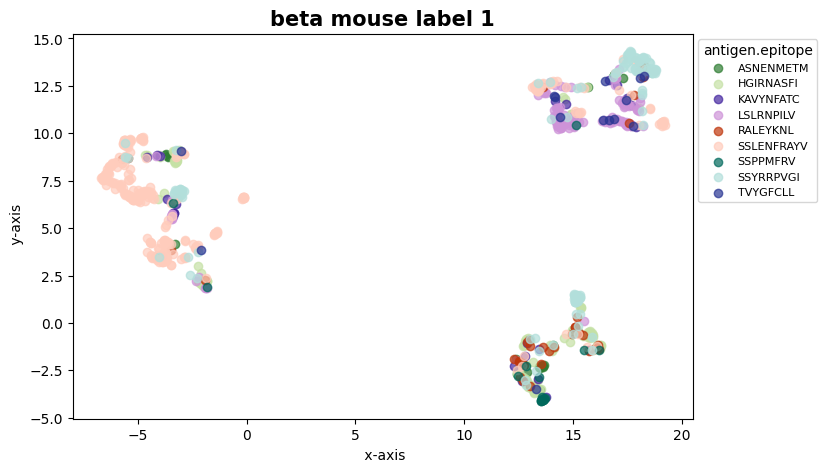

In [57]:
label = 1
bool = np.isin(cluster_results[:, -1], label)
cluster_1_coordinate = cluster_results[bool][:, 0:-1]
clone_df_1 = mouse_beta_clone_df[mouse_beta_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=40, min_dist=0.2, random_state=42)
embedding1 = reducer_umap.fit_transform(cluster_1_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_1['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_1['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_1 = clone_df_1[mask]
filtered_embedding1 = embedding1[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_1['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_1['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding1[true_indices, 0], filtered_embedding1[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta mouse label 1', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_beta_1.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


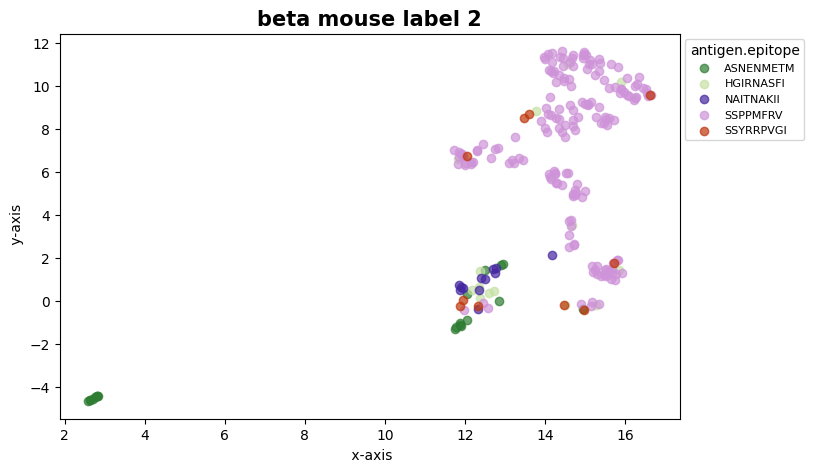

In [58]:
label = 2
bool = np.isin(cluster_results[:, -1], label)
cluster_2_coordinate = cluster_results[bool][:, 0:-1]
clone_df_2 = mouse_beta_clone_df[mouse_beta_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=30, min_dist=0.2, random_state=42)
embedding2 = reducer_umap.fit_transform(cluster_2_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_2['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_2['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_2 = clone_df_2[mask]
filtered_embedding2 = embedding2[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_2['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_2['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding2[true_indices, 0], filtered_embedding2[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta mouse label 2', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_beta_2.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


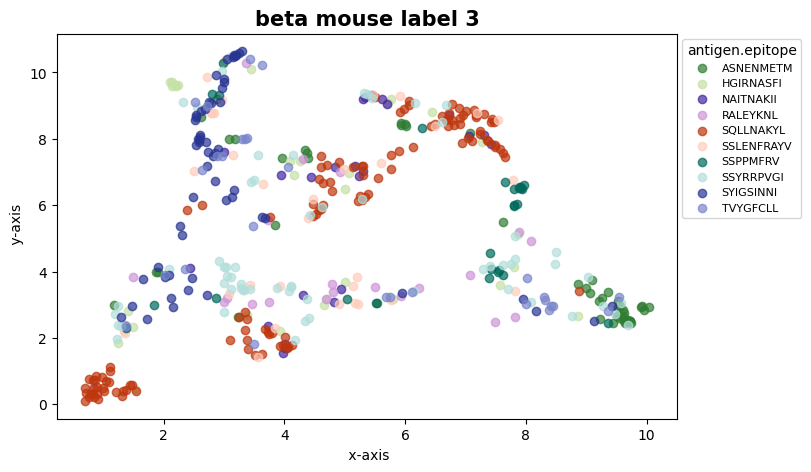

In [59]:
label = 3
bool = np.isin(cluster_results[:, -1], label)
cluster_3_coordinate = cluster_results[bool][:, 0:-1]
clone_df_3 = mouse_beta_clone_df[mouse_beta_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=50, min_dist=0.2, random_state=42)
embedding3 = reducer_umap.fit_transform(cluster_3_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_3['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 20].index

# Search those specificities
mask = clone_df_3['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_3 = clone_df_3[mask]
filtered_embedding3 = embedding3[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_3['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_3['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding3[true_indices, 0], filtered_embedding3[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta mouse label 3', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_beta_3.png')
plt.show()

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


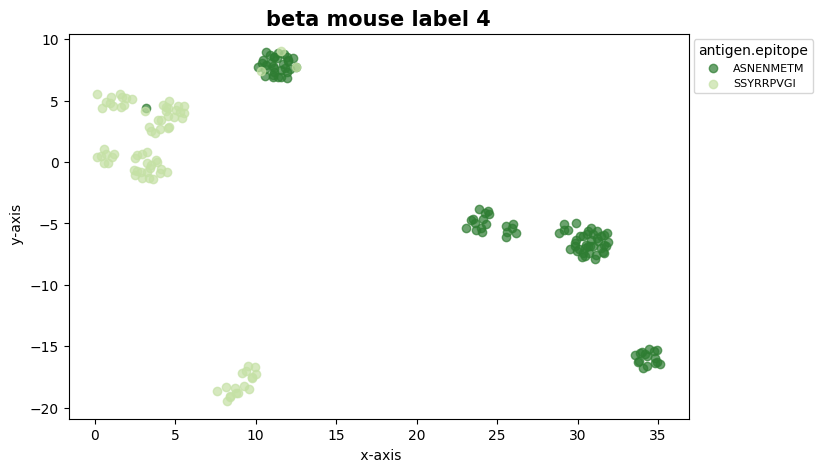

In [60]:
label = 4
bool = np.isin(cluster_results[:, -1], label)
cluster_4_coordinate = cluster_results[bool][:, 0:-1]
clone_df_4 = mouse_beta_clone_df[mouse_beta_clone_df['label'] == label]

reducer_umap = umap.UMAP(n_neighbors=80, min_dist=0.9, random_state=42)
embedding4 = reducer_umap.fit_transform(cluster_4_coordinate)


# count the appearance times of each specificity
specificity_counts = clone_df_4['antigen.epitope'].value_counts()

# find out the specificities' number larger 10
valid_specificity = specificity_counts[specificity_counts >= 10].index

# Search those specificities
mask = clone_df_4['antigen.epitope'].isin(valid_specificity)

filtered_clone_df_4 = clone_df_4[mask]
filtered_embedding4 = embedding4[mask]

color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]

unique_antigen_species = np.unique(filtered_clone_df_4['antigen.epitope'])
colors = color_list[:len(unique_antigen_species)]
color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indices = (filtered_clone_df_4['antigen.epitope'] == antigen_species)
    plt.scatter(filtered_embedding4[true_indices, 0], filtered_embedding4[true_indices, 1], color=color, label=antigen_species,
                alpha=0.7)


plt.title('beta mouse label 4', fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('mouse_beta_4.png')
plt.show()